「このノートブックの冒頭では、CSVファイルなどのデータを扱うための pandas と numpy、

そしてニューラルネットワークの構築・学習のために PyTorch をインポートしています。

また、データを標準化したり、学習用と検証用に分けたりするための scikit-learn も使っています。」

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


今いる作業ディレクトリを確認するために os.getcwd() を使っています。

これによって、相対パスでファイルを読み込むときに、正しく指定できているか確認できます

In [2]:
import os
print(os.getcwd())

c:\Users\21td031\Documents\motion2music\notebooks


このコードでは、指定フォルダ内のCSVファイルをすべて読み込んで、各動画の特徴量を一つの大きな行列にまとめています。

特徴量のスケールが学習に影響しないように、標準化（平均0・分散1）も行っています。

これによって、ニューラルネットワークにそのまま入力できる形式が整います

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# データフォルダ
data_dir = "../data/normalized_features/default"

# すべてのCSVファイルを読み込む
feature_list = []
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        filepath = os.path.join(data_dir, filename)
        df = pd.read_csv(filepath)
        if 'frame' in df.columns:
            df = df.drop(columns=['frame'])  # frame列を除外
        feature_list.append(df.values)

# 結合（すべての動画のフレームを縦方向に並べる）
X = np.vstack(feature_list)

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"読み込んだファイル数: {len(feature_list)}")
print(f"結合後の特徴量行列サイズ: {X_scaled.shape}")


読み込んだファイル数: 19
結合後の特徴量行列サイズ: (2555, 66)


In [4]:
X_scaled

array([[ 0.85130167, -1.56608438,  1.00851649, ...,  1.73513061,
        -0.94592236,  2.41523399],
       [ 0.91397217, -1.8910801 ,  1.12466991, ...,  2.22486407,
        -0.89867318,  2.93361435],
       [ 0.9703862 , -1.07675145,  1.0736464 , ...,  1.09552903,
        -0.91099721,  0.98585443],
       ...,
       [ 1.04751366, -1.37117365,  1.07892969, ...,  1.63043187,
        -0.91268464,  1.77423619],
       [ 1.07438679, -1.39090221,  1.10525926, ...,  1.78960718,
        -0.91935422,  1.75384706],
       [ 1.08114351, -1.38620592,  1.1157006 , ...,  1.8428156 ,
        -0.93413029,  1.7292488 ]])

この MotionDataset クラスは、動画から得た特徴量データを PyTorch で扱いやすい形（テンソル）に変えて、1フレームごとに取り出せるようにするものです。

PyTorchはこの形式じゃないと学習ができないので、まずこの変換が必要になります

In [5]:
#PyTorch用のDatasetクラスを定義
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MotionDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return self.data.shape[0]  # データの行数（＝フレーム数）
    
    def __getitem__(self, idx):
        return self.data[idx]


標準化した特徴量データを訓練用と検証用に8:2で分けています。

そのあとで、それぞれをPyTorch用の MotionDataset クラスに変換して、1フレームごとのテンソルとして学習に使えるようにしています

In [6]:
#データを訓練／検証に分割
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

train_dataset = MotionDataset(X_train)
val_dataset = MotionDataset(X_val)


PyTorchの DataLoader を使って、さっき作った MotionDataset から32件ずつデータを取り出せるようにしています。

訓練用はシャッフルして、検証用はシャッフルせずに、毎回同じ順番で使えるようにしています

In [7]:
#DataLoaderを作成
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [8]:
for batch in train_loader:
    print(batch.shape)  # → torch.Size([32, 特徴量数])
    break


torch.Size([32, 66])


このコードではAutoEncoderというニューラルネットワークを作って、動画から得た特徴量を圧縮・復元するように学習させています。

学習後にはモデルと標準化のスケーラーを保存して、あとからAPIなどで使えるようにしています。

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import joblib
import os

# ================================
# AutoEncoderモデルの定義
# ================================
class AutoEncoder(nn.Module):
    def __init__(self, input_dim=66, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# ================================
# データセットクラス（再掲）
# ================================
class MotionDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]

# ================================
# 学習準備
# ================================
# X_scaled：前のステップで標準化された特徴量行列
input_dim = X_scaled.shape[1]
latent_dim = 8

X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)
train_dataset = MotionDataset(X_train)
val_dataset = MotionDataset(X_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ================================
# 学習ループ
# ================================
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            val_loss += loss.item()

    print(f"Epoch {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# ================================
# モデルとスケーラーを保存
# ================================
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "../models/ae_model.pt")
joblib.dump(scaler, "../models/scaler.joblib")
print("モデルとスケーラーを保存しました。")


Epoch  1/100 | Train Loss: 66.7312 | Val Loss: 4.2339
Epoch  2/100 | Train Loss: 44.0785 | Val Loss: 3.4065
Epoch  3/100 | Train Loss: 32.2472 | Val Loss: 3.4038
Epoch  4/100 | Train Loss: 28.6404 | Val Loss: 3.1261
Epoch  5/100 | Train Loss: 26.4869 | Val Loss: 2.8491
Epoch  6/100 | Train Loss: 28.1194 | Val Loss: 2.5362
Epoch  7/100 | Train Loss: 26.2094 | Val Loss: 2.1584
Epoch  8/100 | Train Loss: 20.4178 | Val Loss: 2.0006
Epoch  9/100 | Train Loss: 21.7219 | Val Loss: 2.0034
Epoch 10/100 | Train Loss: 23.6708 | Val Loss: 2.2219
Epoch 11/100 | Train Loss: 22.4961 | Val Loss: 2.1779
Epoch 12/100 | Train Loss: 21.6677 | Val Loss: 2.0379
Epoch 13/100 | Train Loss: 23.3193 | Val Loss: 2.4737
Epoch 14/100 | Train Loss: 23.1563 | Val Loss: 2.0598
Epoch 15/100 | Train Loss: 13.1305 | Val Loss: 2.1175
Epoch 16/100 | Train Loss: 22.5552 | Val Loss: 2.0769
Epoch 17/100 | Train Loss: 9.6370 | Val Loss: 1.5985
Epoch 18/100 | Train Loss: 6.9617 | Val Loss: 1.7341
Epoch 19/100 | Train Loss: 12.

この関数は、学習済みのAutoEncoderを使って、複数の特徴量CSVを一括で次元圧縮（latent特徴量に変換）し、新しいCSVファイルとして保存します。

入力は各フレームの66次元の特徴量で、出力は8次元の潜在変数になります。

データ前処理（スケーリング）も自動で行い、frame列も保持するようになっています

In [10]:
import os
import pandas as pd
import torch
import joblib
from tqdm import tqdm

# 必要なら AutoEncoder クラスもここに入れる or import
# from model import AutoEncoder

def extract_latent_all(
    model_path,
    scaler_path,
    input_dir,
    output_dir,
    input_dim=66,
    latent_dim=8,
    device="cpu"
):
    # モデル＆スケーラーの読み込み
    scaler = joblib.load(scaler_path)
    model = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    os.makedirs(output_dir, exist_ok=True)

    for filename in tqdm(os.listdir(input_dir)):
        if not filename.endswith(".csv"):
            continue

        input_path = os.path.join(input_dir, filename)
        output_name = filename.replace(".csv", "_latent.csv")
        output_path = os.path.join(output_dir, output_name)

        try:
            df = pd.read_csv(input_path)
            frames = df['frame'].values if 'frame' in df.columns else range(len(df))
            X = df.drop(columns=['frame'], errors='ignore').values
            X_scaled = scaler.transform(X)

            with torch.no_grad():
                inputs = torch.tensor(X_scaled, dtype=torch.float32).to(device)
                z = model.encoder(inputs).cpu().numpy()

            latent_df = pd.DataFrame(z, columns=[f'latent_{i}' for i in range(z.shape[1])])
            latent_df.insert(0, 'frame', frames)
            latent_df.to_csv(output_path, index=False)

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

    print("✅ すべてのファイルに対してlatent変換が完了しました。")


In [11]:
extract_latent_all(
    model_path="../models/ae_model.pt",
    scaler_path="../models/scaler.joblib",
    input_dir="../data/normalized_features/default",
    output_dir="../data/latent",
    input_dim=66,
    latent_dim=8,
    device="cpu"
)


100%|██████████| 19/19 [00:00<00:00, 34.11it/s]

✅ すべてのファイルに対してlatent変換が完了しました。


100%|██████████| 19/19 [00:00<00:00, 83.48it/s]


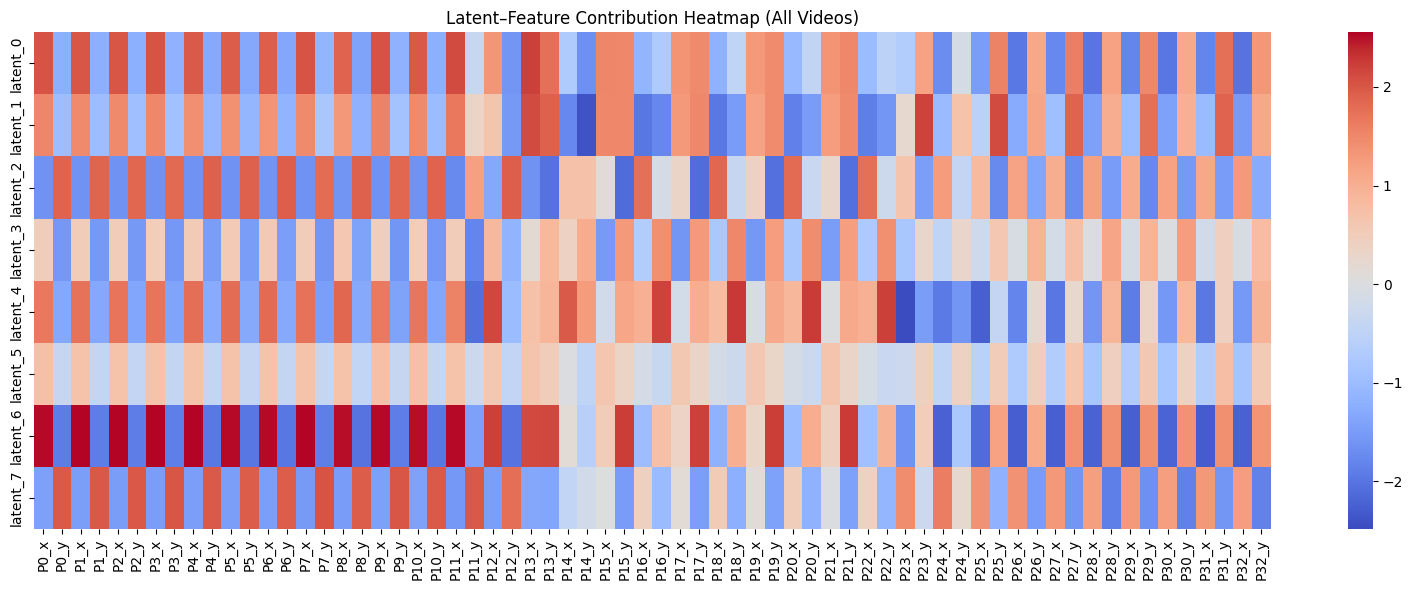

In [12]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from joblib import load
from tqdm import tqdm

# パス設定
input_dir = "../data/normalized_features/default"
model_path = "../models/ae_model.pt"
scaler_path = "../models/scaler.joblib"

# AEモデル定義（または from model import AutoEncoder）
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim=66, latent_dim=8):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, latent_dim)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 24),
            torch.nn.ReLU(),
            torch.nn.Linear(24, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

# モデル・スケーラー読み込み
model = AutoEncoder(input_dim=66, latent_dim=8)
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.eval()

scaler = load(scaler_path)

# 全CSVを読み込んで特徴量とlatentを集める
X_all = []
Z_all = []

for filename in tqdm(os.listdir(input_dir)):
    if not filename.endswith(".csv"):
        continue
    filepath = os.path.join(input_dir, filename)
    df = pd.read_csv(filepath)
    X = df.drop(columns=["frame"], errors="ignore").values
    X_scaled = scaler.transform(X)

    with torch.no_grad():
        inputs = torch.tensor(X_scaled, dtype=torch.float32)
        Z = model.encoder(inputs).numpy()

    X_all.append(X_scaled)
    Z_all.append(Z)

# 結合
X_all = np.vstack(X_all)
Z_all = np.vstack(Z_all)

# 特徴量・latent名
feature_names = df.columns.drop("frame", errors="ignore")
latent_names = [f"latent_{i}" for i in range(Z_all.shape[1])]

# DataFrame化
df_X = pd.DataFrame(X_all, columns=feature_names)
df_Z = pd.DataFrame(Z_all, columns=latent_names)

# 相関行列（latent × feature）
correlation = df_Z.T.dot(df_X) / len(df_X)  # 共分散ベースの寄与

# 可視化（ヒートマップ）
plt.figure(figsize=(16, 6))
sns.heatmap(correlation, cmap="coolwarm", xticklabels=feature_names, yticklabels=latent_names)
plt.title("Latent–Feature Contribution Heatmap (All Videos)")
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import numpy as np

# 相関行列をコピー（DataFrame形式であることを前提）
contrib = correlation.copy()

# 上位特徴量を抽出（絶対値が高いもの）
top_k = 5  # 上位何個を出すか
top_features = {}

for latent in contrib.index:
    abs_corr = contrib.loc[latent].abs()
    top_feats = abs_corr.sort_values(ascending=False).head(top_k).index.tolist()
    top_features[latent] = top_feats

# 出力
for latent, features in top_features.items():
    print(f"\n🔹 {latent} に寄与するTop{top_k}特徴量:")
    for i, feat in enumerate(features, 1):
        val = contrib.loc[latent, feat]
        print(f"  {i}. {feat} (寄与: {val:.3f})")



🔹 latent_0 に寄与するTop5特徴量:
  1. P13_x (寄与: 2.203)
  2. P11_x (寄与: 2.112)
  3. P9_x (寄与: 2.054)
  4. P0_x (寄与: 2.033)
  5. P3_x (寄与: 2.032)

🔹 latent_1 に寄与するTop5特徴量:
  1. P14_y (寄与: -2.401)
  2. P23_y (寄与: 2.200)
  3. P25_y (寄与: 2.114)
  4. P13_x (寄与: 2.113)
  5. P16_x (寄与: -1.970)

🔹 latent_2 に寄与するTop5特徴量:
  1. P15_y (寄与: -2.113)
  2. P17_y (寄与: -2.104)
  3. P19_y (寄与: -2.064)
  4. P21_y (寄与: -2.062)
  5. P13_y (寄与: -2.043)

🔹 latent_3 に寄与するTop5特徴量:
  1. P11_y (寄与: -1.801)
  2. P17_x (寄与: -1.593)
  3. P7_y (寄与: -1.587)
  4. P9_y (寄与: -1.586)
  5. P0_y (寄与: -1.570)

🔹 latent_4 に寄与するTop5特徴量:
  1. P23_x (寄与: -2.481)
  2. P18_y (寄与: 2.265)
  3. P25_x (寄与: -2.255)
  4. P20_y (寄与: 2.249)
  5. P22_y (寄与: 2.210)

🔹 latent_5 に寄与するTop5特徴量:
  1. P32_x (寄与: -0.854)
  2. P30_x (寄与: -0.841)
  3. P28_x (寄与: -0.834)
  4. P31_y (寄与: 0.774)
  5. P10_x (寄与: 0.736)

🔹 latent_6 に寄与するTop5特徴量:
  1. P3_x (寄与: 2.554)
  2. P2_x (寄与: 2.552)
  3. P7_x (寄与: 2.551)
  4. P1_x (寄与: 2.550)
  5. P4_x (寄与: 2.538)

🔹 late

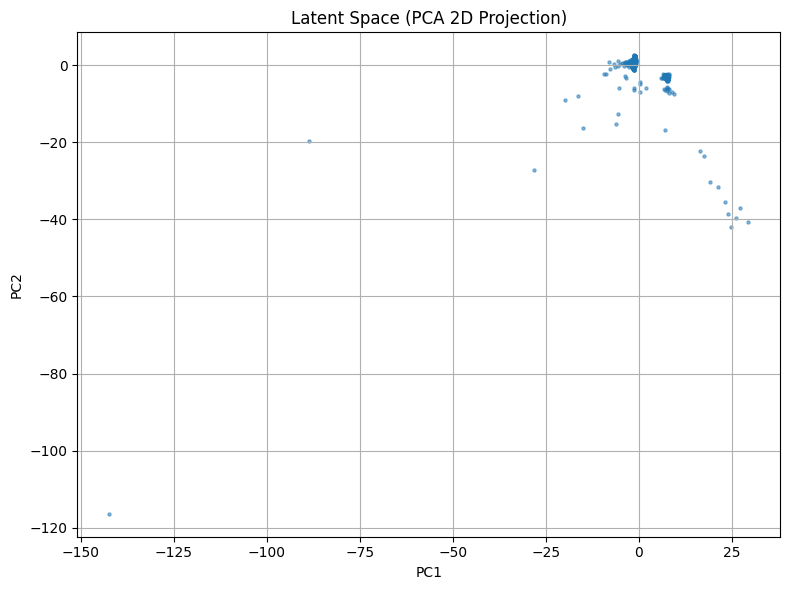

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# latent_all: 全動画フレーム × 8次元 のlatentベクトル（前ステップのZ_all）

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(Z_all)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=5, alpha=0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Latent Space (PCA 2D Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()


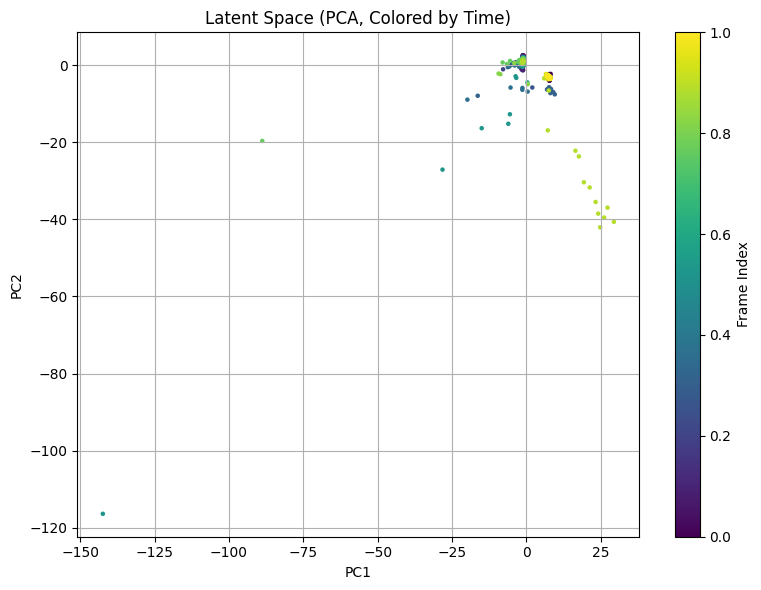

In [15]:
import numpy as np

# optional: 時間インデックスで色をつける
colors = np.linspace(0, 1, len(latent_2d))

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, cmap='viridis', s=5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Latent Space (PCA, Colored by Time)")
plt.colorbar(label='Frame Index')
plt.grid(True)
plt.tight_layout()
plt.show()


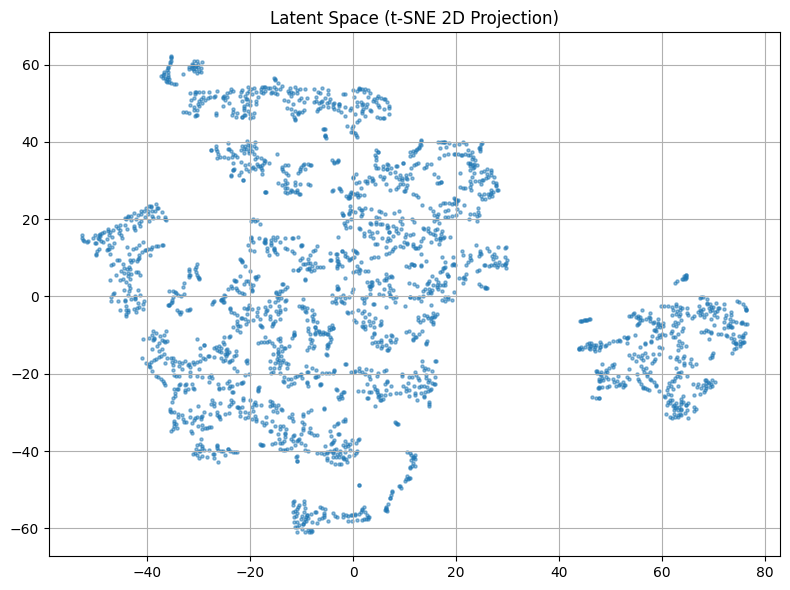

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Z_all: 全動画フレーム × 8次元のlatentベクトル

# ⚠️ データ数が多すぎると重いので、最初はサンプル制限してもOK
Z_sample = Z_all  # または Z_all[:2000] など

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
Z_tsne = tsne.fit_transform(Z_sample)

plt.figure(figsize=(8, 6))
plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], s=5, alpha=0.5)
plt.title("Latent Space (t-SNE 2D Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()
